Loading files
Loaded 10 files


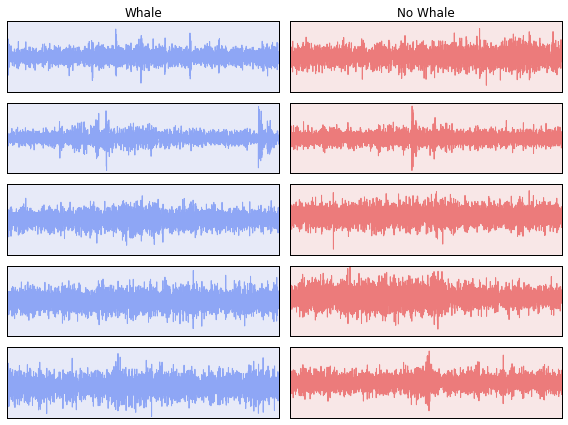

In [1]:
from __future__ import print_function # for keeping consistency with the python 3 print function
from IPython.display import Audio
import numpy as np # standard array processing library
import matplotlib.pyplot as plt # standard data visualization library
%matplotlib inline
from scipy.signal import spectrogram # for, ya know, spectrograms
import gzip # for unpacking zip files
import os # library for os operations
import sys
sys.dont_write_bytecode = True # keeps from writing extra pyc files when we load local files
import utils # utils file from next door

# relative paths to the data. The r is there because backslashes are dicks
h1_dir = r".\sample_data\small_data_sample\right_whale"
h0_dir = r".\sample_data\small_data_sample\no_right_whale"

# couple quick lambda functions to attach filenames to their path
h1_map = lambda fname: os.path.join(h1_dir, fname)
h0_map = lambda fname: os.path.join(h0_dir, fname)

# map those path making functions above onto the lists of path names from os.listdir
h1_files = map(h1_map, os.listdir(h1_dir))
h0_files = map(h0_map, os.listdir(h0_dir))

# now load in our files
print("Loading files")
h1s = map(utils.load_file, h1_files)
h0s = map(utils.load_file, h0_files)
print("Loaded %i files" % (len(h1s) + len(h0s)))

fig = plt.figure(figsize=(8, 6))
h1_color = "#5379f3"
h0_color = "#e53434"
for i, (h1, h0) in enumerate(zip(h1s, h0s)):
    for j, h in enumerate([h1, h0]):
        ax = fig.add_subplot(5, 2, 2*i+j+1)
        ax.plot(np.linspace(0, 2, h.shape[0]), h, color=[h1_color, h0_color][j], alpha=0.6)
        if i == 0:
            ax.set_title(['Whale', 'No Whale'][j])
        ax.set_axis_bgcolor(["#e7eaf8", "#f8e7e7"][j])
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()


Ok, so there's no obvious difference between the whale audio and the whale-absent audio just from the raw signals alone, but this should come as hardly surprising to anyone. The key is to identify the most critical ways in which whale audio and non whale audio differ on average, then find a way to quantify them mathematically and measure them.

Let's demonstrate this by just taking a couple simple statistical measures and see how whale and non whale audio compare.  We'll measure the *mean* value each sample takes, and the *standard deviation* across each sample, and then plot these against one another.

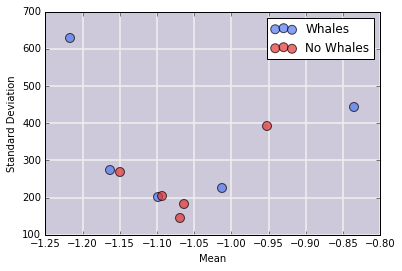

In [2]:
means = map(np.mean, h1s + h0s)
stds = map(np.std, h1s + h0s)
colors = [h1_color]*len(h1s) + [h0_color]*len(h0s)

fig, ax = plt.subplots()
ax.set_axis_bgcolor("#cdc8da")
ax.grid(True)
ax.set_axisbelow(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_color("#eeeeee")
    line.set_linewidth(2)
    line.set_linestyle("-")
    line.set_alpha(0.8)

ax.set_xlabel('Mean')
ax.set_ylabel('Standard Deviation')
ax.scatter(means[:len(h1s)], stds[:len(h1s)], c=h1_color, s=80, alpha=0.7, label='Whales')
ax.scatter(means[len(h1s):], stds[len(h1s):], c=h0_color, s=80, alpha=0.7, label='No Whales')
ax.legend()

So, unsurprisingly, we don't see an obvious difference here as well (I say unsurprisingly because these are extremely simple measurements).  But this captures the essence of what we're trying to do.  Ideally, we would like to see something like this:

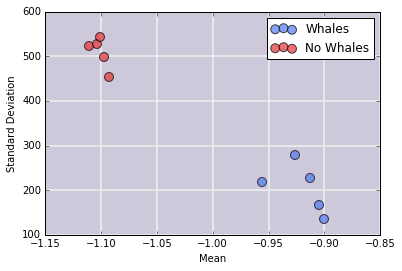

In [3]:
means = np.concatenate([-0.9 + 0.02 * np.random.randn(len(h1s)), -1.1 + 0.02*np.random.randn(len(h0s))])
stds = np.concatenate([200 + 50*np.random.randn(len(h1s)), 500 + 50*np.random.randn(len(h0s))])

colors = [h1_color]*len(h1s) + [h0_color]*len(h0s)

fig, ax = plt.subplots()
ax.set_axis_bgcolor("#cdc8da")
ax.grid(True)
ax.set_axisbelow(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_color("#eeeeee")
    line.set_linewidth(2)
    line.set_linestyle("-")
    line.set_alpha(0.8)

ax.set_xlabel('Mean')
ax.set_ylabel('Standard Deviation')
ax.scatter(means[:len(h1s)], stds[:len(h1s)], c=h1_color, s=80, alpha=0.7, label='Whales')
ax.scatter(means[len(h1s):], stds[len(h1s):], c=h0_color, s=80, alpha=0.7, label='No Whales')
ax.legend()

With this imaginary data, the whales and non whales group up in different regions of our "feature space".  Now, when we get a new data point, if it ends up near the blue cluster, we know that it's a whale, and if it ends up near the red cluster, we know it's not.  The trick is to find the right features such that the clusters separate out like this.

However, even with the best features, life is rarely so simple.  Even in this imaginary example, we still have some unaddressed problems.  For example, what does it mean to be "near" a cluster?  If a point ends up somewhere between these clusters, what do we do?  These problems are only exacerbated by noisier features in much higher dimensional spaces.

One solution, and the smart one, is to accept the uncertainty in our predictions.  Instead of building a function which says "Whale" or "No Whale", we build a function which outputs the *probability* with which a particular sample contains a whale.  A new data point in our example above which ends up between our clusters would then probably be given a probability of somewhere around 0.5, to represent our lack of certainty of which cluster our new point *should* belong to.

This is the essential goal of a machine learning algorithm.  Your job as a scientist is to identify those features which contain the most relevant information for the problem at hand, and build ways to measure them mathematically.  The job of the machine learning algorithm you use is to look at the observed samples (called our **training data**), and from it build a function which takes in samples in this high dimensional feature space and, on average, does the best job of assigning probabilities of containing whale a call (that is, it makes your observed data *likely*).

There are countless ways to build this function, and countless trade offs in optimizing the functions you build.  We'll get more into that later, but for now let's start observing the benefits of feature engineering in practice and start looking at how algorithms respond to good or bad features.


So let's think about this.  When you listen to the whale call audio, you don't hear a bunch of random data points.  What you hear is a characteristic "cooing" sort of sound, which sound like it sort of swings up.  What our auditory system is triggering on is a specific *frequency* signal, or more accurately an upswing in frequency.  Background noise tends to contain equal amounts, or randomly distributed around some equal amount, of *all* frequencies.  However, our whale signal occupies a much more concentrated band of audio frequencies.  Therefore, it might behoove us to look at the amount of each frequency contained in the audio over time and try to see if this phenomenom bears out.  The tool for doing this is a *spectrogram*, which plots time on the x axis, and frequency on the y axis, with a heat map showing the amount of that frequency present at that point in time.  We'll build spectrograms for our sample audio and see if we notice any patterns.

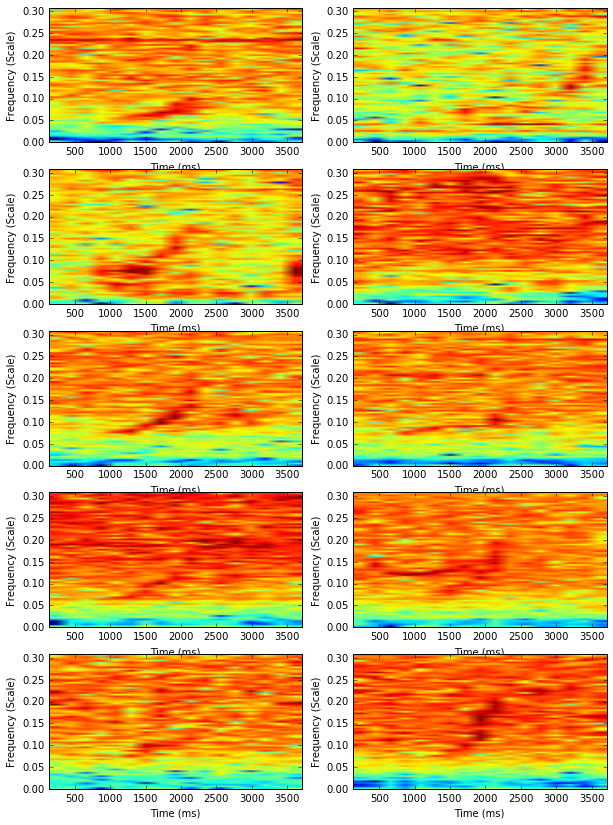

In [4]:
def build_spectrogram(signal):
    frequencies, times, values = spectrogram(signal)
    values = 10*np.log10(values) # to move to decibel space

    # gonna cheat a bit and just look at the frequency ranges I know are relevant
    # just makes the images a bit more clear
    frequencies = frequencies[:80]
    values = values[:80]
    return frequencies, times, values

h1_specs = map(build_spectrogram, h1s)
h0_specs = map(build_spectrogram, h0s)

fig = plt.figure(figsize=(10, 14))
for i, (h1, h0) in enumerate(zip(h1_specs, h0_specs)):
    for j, h in enumerate([h1, h0]):
        ax = fig.add_subplot(5, 2, 2*i+j+1)
        utils.axis_spectrogram(ax, h)

And, holy hell, we might actually see something.  Sure, it's sort of vague, and these could use some cleaning up, but we might just be able to sort of make out a "hot streak" in our whale samples that corresponds to the call!  Now our problem has been reduced to characterizing that hot streak and checking for its presence our absence.

We'll start again with some simple features.  Instead of looking at the mean and standard deviation across the whole sample, let's measure the mean and standard deviation across *each frequency bin*.  Sure, some of these frequencies are still just noise, but you can imagine that in the whale signals, the mean amount of frequency present in the bins corresponding to the call should be higher (a similar logic could apply to the standard deviation).  I'm not promising these features are perfect, or even *good* frankly, but we have to start somewhere, so let's see how our samples separate out using these.

But wait!  There's about 80 frequency bins we're going to look at, and I'm measuring the mean and standard deviation for each one of those bins, which amounts to 160 features total.  Accordingly, our feature space is 160-dimensional, which is pretty difficult to visualize in the same way we visualized our 2-dimensional feature space above.  To deal with this, we'll perform a pretty standard machine learning method called **Principle Component Analysis** (PCA).  What PCA does is take high dimensional data, like what we have, and project it onto lower dimensional spaces (we'll pick 2 for the purposes of visualization) along axes which contain the most information about the space (mathematically, these are the axes that capture the most variance in the data).  Luckily for us, the sklearn library already has this implemented out-of-the-box, though I would recommend reading up on some of the math behind it anyway; the algorithm is surprisingly simple but extremely powerful and illuminating about the stats of high dimensional data spaces.

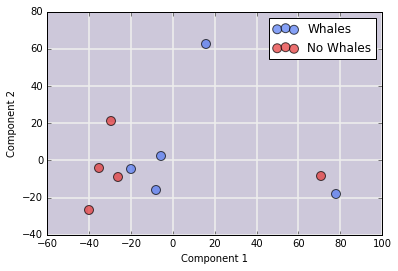

In [5]:
def get_stats(spec):
    means = spec.mean(axis=-1)
    stds = spec.std(axis=-1)
    return np.concatenate([means, stds])

h1_stats = map(get_stats, [i[-1][:80] for i in h1_specs])
h0_stats = map(get_stats, [i[-1][:80] for i in h0_specs])

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(np.array(h1_stats + h0_stats))
component1 = transformed_data[:, 0]
component2 = transformed_data[:, 1]

fig, ax = plt.subplots()
ax.set_axis_bgcolor("#cdc8da")
ax.grid(True)
ax.set_axisbelow(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_color("#eeeeee")
    line.set_linewidth(2)
    line.set_linestyle("-")
    line.set_alpha(0.8)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.scatter(component1[:len(h1s)], component2[:len(h1s)], c=h1_color, s=80, alpha=0.7, label='Whales')
ax.scatter(component1[len(h1s):], component2[len(h1s):], c=h0_color, s=80, alpha=0.7, label='No Whales')
ax.legend()

And just like that, by extremely simple feature engineering, we've started to separate our data!  Sure, it's far from perfect, but we're certainly a long way from the total jumble we had above.  Let's start with these less-than-ideal features and train a machine learning algorithm to establish a baseline performance from which we can improve.